In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

data = pd.read_csv("Cancer_Data.csv").drop(columns={"Unnamed: 32"})

X = data.drop(columns={"diagnosis"})
y = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
X = X.drop(columns={"id"})
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [48]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Step 1: Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KFold with 5 splits for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a DataFrame to store feature importances from each fold
feature_importances = pd.DataFrame(index=X_train.columns)

# Step 2: K-Fold Cross-validation on the training set
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    # Standardize only the training data for cross-validation
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cv), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_cv), columns=X_train.columns)

    # Initialize and train the model on the training data
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train_cv)

    # Get the feature importances from the trained model
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importances[f'Fold_{fold+1}'] = importances

# Step 3: Calculate the mean of the feature importances from all folds
feature_importances['Mean'] = feature_importances.mean(axis=1)

# Step 4: Select the top 10 most important features
top_features = feature_importances['Mean'].nlargest(10).index

# Print the top features
print("Top 10 Features Based on Feature Importance:")
print(top_features)


Top 10 Features Based on Feature Importance:
Index(['area_worst', 'concave points_worst', 'concave points_mean',
       'perimeter_worst', 'concavity_mean', 'radius_worst', 'perimeter_mean',
       'radius_mean', 'area_mean', 'concavity_worst'],
      dtype='object')


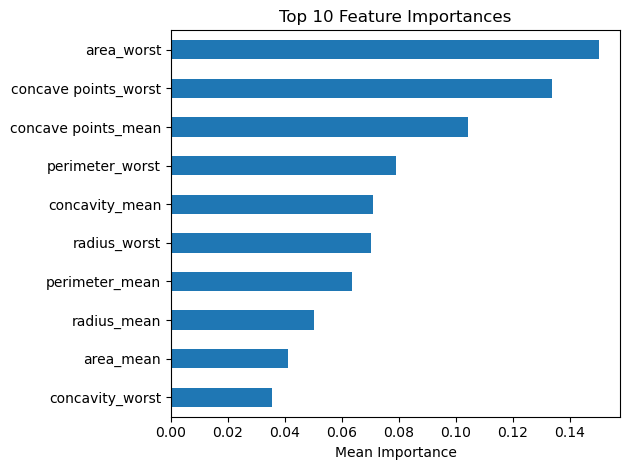

In [49]:
import matplotlib.pyplot as plt

#bar plot for feature importance
feature_importances.loc[top_features, 'Mean'].sort_values().plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#define grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}

#use data from top features only in training
X_top = X_train[top_features]
scaler = StandardScaler()
X_top_scaled = pd.DataFrame(scaler.fit_transform(X_top), columns=top_features)

#perform grid search with k fold cross validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_top_scaled, y_train)

#combination with highest average cross validation score saved
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


Train Accuracy: 0.9538
Test Accuracy: 0.9649


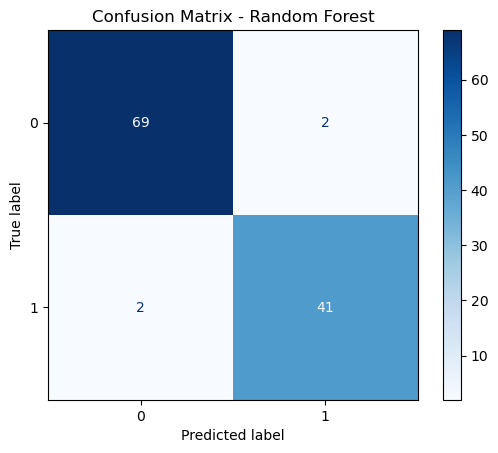

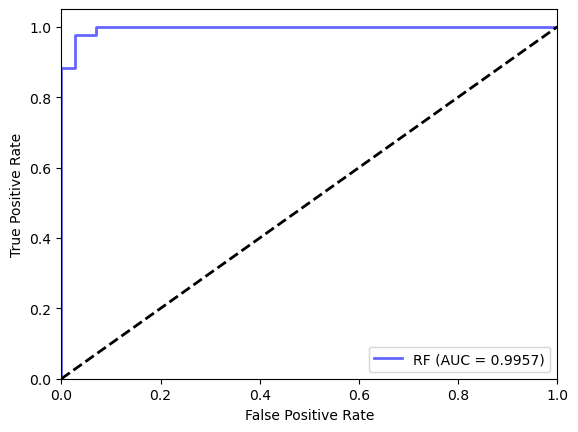

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Use the top features to subset the training and test sets
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Initialize the RandomForest model with the best hyperparameters
model = RandomForestClassifier(**best_params)

# Train the model on the whole training set with selected features
model.fit(X_train_top, y_train)

# Predict on the training set and the test set
y_train_pred = model.predict_proba(X_train_top)[:,1]
threshold=.3
y_pred_adjusted_train= (y_train_pred >= threshold).astype(int)
y_test_pred = model.predict_proba(X_test_top)[:,1]
threshold=.3
y_pred_adjusted_test= (y_test_pred >= threshold).astype(int)

# Calculate accuracy for both training and test sets
train_accuracy = accuracy_score(y_train, y_pred_adjusted_train)
test_accuracy = accuracy_score(y_test, y_pred_adjusted_test)

# Print accuracy results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix for both train and test sets
train_cm = confusion_matrix(y_train, y_pred_adjusted_train)
test_cm = confusion_matrix(y_test, y_pred_adjusted_test)

# Display confusion matrix for the test set
disp_rf2 = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp_rf2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve (for the test set)
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_top)[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, alpha=0.6, label='RF (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png", transparent=True, dpi=300)
plt.show()
